Here is my analysis of the NFL Draft over the past decade. My goal here is to see how accurately I can predict the results of the 1st round of the NFL Draft based solely on a player's college stats in their last college season and their combine results. Some factors not considered in this analysis are a player's college film and their individualized team scouting reports. In some ways, this analysis will be a test to see how much one's draft position is based on stats and physique versus film and personality. Or the two may not be entirely independent. Does a player's stats sometimes affect how a scout will review their film? 

I will be using the 2010-2019 drafts as my training set, and the 2020 draft as my test set. The most obvious measure of success would be comparing my results to the actual 2020 draft and seeing how many picks I got exactly correct. However, correctly predicting exact draft positions beyond the first couple is nearly impossible for a few reasons. Firstly, a team may draft a 'worse' player that fits a team need over a better player, and it is quite hard to implement team needs, which change each season, into my model. Secondly, there are always multiple draft day trades that are virtually impossible to predict and account for without insider sources around the league. And thirdly, sometimes news stories break right before the draft that can greatly affect a player's draft stock, particularly when these stories pertain to off field behavioral issues. Even experts with better access to this information than I do would be thrilled to get even 10 picks exactly correct in the first round.

Therefore, I will instead be treating my model like a board of the best players available, regardless of draft order, and I will measure my success in two ways. First, I will look at the percent of players I correctly predict to go in the first round, and compare that to the percent that an expert's ranking got correct. Second, I will use my model as a predictor of NFL success by looking at how my predicted first round players performed in the NFL, and I will compare that to both the expert's rankings and the actual draft order. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

pd.set_option('display.max_columns', None)

df = pd.read_csv('cleaner_draft_data_10_20.csv')

df = df.sort_values('Unnamed: 0')

df.drop(df.loc[:,df.columns.str.contains('NFL')], axis=1, inplace=True)
df.drop(df.loc[:,df.columns[47:56]], axis=1, inplace=True)
df.drop('Pts', axis=1, inplace=True)
d = {'College/Univ':'College'}
di = {'Unnamed: 0':'index'}
df.rename(d, axis=1, inplace=True)
df.rename(di, axis=1, inplace=True)

df.set_index('index', inplace=True)
df.drop([2070, 2330, 102, 1812, 320, 2741, 971, 972, 973, 1583, 1584, 1586, 316, 2361, 2406, 2517, 582, 1494, 1044, 2051, 1695, 2417, 1981, 2175, 471, 1233, 864, 2096], inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [2]:
df[['Ht', 'Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']] = df.groupby('Pos')['Ht', 'Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle'].transform(lambda x: x.fillna(x.mean()))

for i in df.columns[14:]:
    df[i].fillna(0, inplace=True)
    
df['Draft.Yr'] = df['Drafted (tm/rnd/yr)'].str.split('/')
years = []

for index, item in df.iterrows():
    try:
        year = item['Draft.Yr'][-1]
        
    except TypeError:
        year = np.nan
    years.append(year)
    
df['Year'] = years

df['Year'].fillna(method='ffill', inplace=True)
df['Year'] = df['Year'].astype('int64')
df.drop(['Draft.Yr', 'Drafted (tm/rnd/yr)'], axis=1, inplace=True)

df['AV/Yr'] = df['CarAV']/(df['To']-df['Year'] + 1)

sb09 = {'Cmp':39, 'Pass.Att':69, 'Pct':56.5, 'Pass.Yds':562, 'Pass.TD':2, 'Pass.Int':0, 'Rate':134.5, 'Rush.Att':4, 'Rush.Yds':-18, 'Rush.Avg':-4.5, 'Rush.TD':0}
sb08 = {'Cmp':328, 'Pass.Att':483, 'Pct':67.9, 'Pass.Yds':4720, 'Pass.TD':50, 'Pass.Int':8, 'Rate':180.8, 'Rush.Att':42, 'Rush.Yds':47, 'Rush.Avg':1.1, 'Rush.TD':5}
cw00 = {'Cmp':0, 'Pass.Att':0, 'Pct':0, 'Pass.Yds':0, 'Pass.TD':0, 'Pass.Int':0, 'Rate':0, 'Rush.Att':0, 'Rush.Yds':0, 'Rush.Avg':0, 'Rush.TD':0}
cw14 = {'Cmp':228, 'Pass.Att':358, 'Pct':63.7, 'Pass.Yds':3111, 'Pass.TD':25, 'Pass.Int':10, 'Rate':154.1, 'Rush.Att':138, 'Rush.Yds':642, 'Rush.Avg':4.7, 'Rush.TD':6}

df.iloc[0:1] = df.iloc[0:1].replace(to_replace=sb09, value=sb08)
df.iloc[1509:1510] = df.iloc[1509:1510].replace(to_replace=cw00, value=cw14)


<ipython-input-2-7102b48dfb51>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[['Ht', 'Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']] = df.groupby('Pos')['Ht', 'Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle'].transform(lambda x: x.fillna(x.mean()))


First I import and clean the data. The notebook I used to import and do most of the cleaning will be uploaded separately. All the data is collected from Pro-Football-Reference.com. 

Since I'm only looking at college stats I dropped the NFL stats. I do however want to keep each player's Approximate Value per Year, as it will be useful for looking backwards to see if more value comes from players drafted in the first round based on my model, the experts' models, or the actual draft.

For missing height, weight, and combine data, I filled it with the mean value based on each position. I also scraped just the year out of the column 'Drafted (tm/rnd/yr)'.

Finally, there are two known irregularites in my data that may cause some errors in my results. Those are players with duplicate names, and injury shortened final college seasons. The only injury seasons I changed (replaced with previous season's stats) were Sam Bradford's  and Carson Wentz's since they missed over half their games and were both picked in the top 2, so that seems like it would have a significant impact on the results. Beyond that, there's just too many players to sift through and determine if injury significantly hampered their seasons. For players with identical names, I tried to sift through as many as I could and deleted the extra copies that were created based on how I created this dataframe. I know I got all the first rounders cleaned correctly. There may be some deeper round picks that I missed.


In [3]:
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error


rfr = RandomForestRegressor(random_state=0)
en = ElasticNet(random_state=0)
rid = Ridge(random_state=0)
linreg = LinearRegression()
vote = VotingRegressor(estimators = [('rf', rfr), ('en', en), ('rid', rid), ('linreg', linreg)], weights=[1,1,1,1]) 

rel_cols = df.columns[4:5].append(df.columns[14:-2])
player_info = df[['Player', 'Pos', 'Year', 'AV/Yr']]

pre_2020 = df[df['Year']<2020]
yr_2020 = df[df['Year']==2020]

X_train_h = pre_2020[rel_cols]
X_train_h = pd.get_dummies(X_train_h)
y_train = pre_2020['Pick']
X_test_h = yr_2020[rel_cols]
X_test_h = pd.get_dummies(X_test_h)
y_test = yr_2020['Pick']

train_cols = X_train_h.columns.intersection(X_test_h.columns)
test_cols = X_test_h.columns.intersection(X_train_h.columns)

X_train = X_train_h[train_cols]
X_test = X_test_h[test_cols]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

model = vote.fit(X_train, y_train)

y_predict = model.predict(X_test)

mse = mean_squared_error(y_test, y_predict)

print('Mean Squared Error:', mse)

output = pd.DataFrame({'Id':X_test.index, 'Pick':y_predict})
output_2020 = output.merge(player_info, how='left', left_on='Id', right_on=player_info.index)



Mean Squared Error: 4471.493017910848


C:\Python\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3351.729233207181, tolerance: 1347.543367052716
  model = cd_fast.enet_coordinate_descent(


Originally, I thought running a regression model on each position separately would yield more accurate results since different stats are of different relevance for each position. After some epxerimentation, that turned out to be wrong, and I got more accurate results (lowest MSE) when I ran the regression on the draft data as a whole. 

Note: my results with each model broken down by position will also be uploaded in a separate notebook.

In [4]:
pff = pd.read_html('https://www.drafttek.com/2020-NFL-Draft-Big-Board/Top-NFL-Draft-Prospects-2020-Page-1.asp', skiprows=1)
pff1 = pd.read_html('https://www.drafttek.com/2020-NFL-Draft-Big-Board/Top-NFL-Draft-Prospects-2020-Page-2.asp', skiprows=1)
pff2 = pd.read_html('https://www.drafttek.com/2020-NFL-Draft-Big-Board/Top-NFL-Draft-Prospects-2020-Page-3.asp', skiprows=1)
bb1 = pff[0]
bb2 = pff1[0]
bb3 = pff2[0]

bb = pd.concat([bb1, bb2, bb3])

big_board = bb[[0, 2]]

d = {0:'Expert_Rank', 2:'Player'}
big_board = big_board.rename(mapper=d, axis=1)

test_df = df[['Pick', 'Player']]
test_df['Actual_Pick'] = test_df['Pick']
test_df = test_df.reset_index()
test_df.drop(['Pick', 'index'] , axis=1, inplace=True)

output_2020 = output_2020.merge(test_df, how='left', left_on='Player', right_on=test_df['Player'])
output_2020.drop(['Id', 'Player_x', 'Player_y'], axis=1, inplace=True)
output_2020['Pick_Ordinal'] = output_2020['Pick'].rank(method='first')
output_2020['Pick_Distance'] = output_2020['Actual_Pick'] - output_2020['Pick_Ordinal']
output_2020.fillna(0, inplace=True)

output_2020 = output_2020.merge(big_board, how='left', on='Player')
output_2020['AV_Rank'] = output_2020['AV/Yr'].rank(method='min', ascending=False)

output_2020.iloc[9] = output_2020.iloc[9].fillna(16)
output_2020.iloc[2] = output_2020.iloc[2].fillna(3)
output_2020.iloc[54] = output_2020.iloc[54].fillna(54)
output_2020.iloc[44] = output_2020.iloc[44].fillna(32)
output_2020.iloc[34] = output_2020.iloc[34].fillna(29)
output_2020.iloc[81] = output_2020.iloc[81].fillna(45)
output_2020.iloc[15] = output_2020.iloc[15].fillna(38)
display(output_2020.sort_values('Pick').head(32))

MSEoP = np.square(np.subtract(output_2020['Actual_Pick'], output_2020['Pick_Ordinal'])).mean()
MSEeR = np.square(np.subtract(output_2020['Actual_Pick'], output_2020['Expert_Rank'])).mean()
print('MSE Ordinal Pick:', MSEoP)
print('MSE Expert Rank:', MSEeR)

<ipython-input-4-42e4a99c56a0>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Actual_Pick'] = test_df['Pick']


,Player,Pick,Pos,Year,AV/Yr,Actual_Pick,Pick_Ordinal,Pick_Distance,Expert_Rank,AV_Rank
0,Joe Burrow,12.860913,QB,2020,7.0,1,1.0,0.0,2.0,12.0
78,Lynn Bowden Jr,38.382761,WR,2020,2.0,80,2.0,78.0,NaN,84.0
12,Tristan Wirfs,51.090063,T,2020,11.0,13,3.0,10.0,7.0,4.0
5,Justin Herbert,54.086755,QB,2020,13.0,6,4.0,2.0,12.0,1.0
7,Isaiah Simmons,54.817884,LB,2020,5.0,8,5.0,3.0,3.0,32.0
24,Brandon Aiyuk,57.852485,WR,2020,6.0,25,6.0,19.0,51.0,21.0
21,Justin Jefferson,66.153245,WR,2020,12.0,22,7.0,15.0,24.0,3.0
1,Chase Young,68.151547,DE,2020,13.0,2,8.0,-6.0,1.0,1.0
48,Chase Claypool,68.293663,WR,2020,7.0,49,9.0,40.0,81.0,12.0
128,James Lynch,68.880835,DT,2020,1.0,130,10.0,120.0,55.0,121.0


MSE Ordinal Pick: 6174.690763052209
MSE Expert Rank: 3094.5135135135133


Here are my final results. When I don't separate by position and use a voting regressor with random forest, elastic net, ridge and linear regression, I get my most accurate results. When trying any of these regressors on the individual positions, I could get a lower MSE for individual positions, but once I concatenated them the MSE was usually over 5000. I thought splitting by position would give more accurate results, but apparently treating position as its own feature is more advantageous. 

For some players, it predicted their draft position very well. Particularly for Joe Burrow, Justin Herbert, Isaiah Simmons, Mekhi Becton, Austin Jackson, Jalen Reagor and Kenneth Murray, who were all predicted within 5 picks of their actual draft position. Even for players who were slightly more off like Chase Young, Tristan Wirfs, Justin Jefferson, Brandon Aiyuk, and Jeff Okudah, I would still consider these all successes as they all were correctly predicted to go in the first round. 

There were also some big misses, like Khalil Davis, Casey Toohill, and Kenny Willekes, who were over 170 picks away from where they were predicted. Though this is much better than earlier iterations of this model where the two latter players were predicted within the top 10. I think earlier versions weighted height and weight too much, giving a large edge to offensive and defensive linemen, but that seems to be mostly worked out now. Of course, Lynn Bowden looks like a pretty big miss as well, but I'm not surprised there either considering he was essentially the entire offense for Kentucky, a Power 5 team, and the model doesn't take strength of college schedule into account.  

In [5]:
av_ranks = output_2020.sort_values('AV_Rank')

pred_count = av_ranks[(av_ranks['Pick_Ordinal']<= 32) & (av_ranks['AV_Rank']<=32)]
exp_count = av_ranks[(av_ranks['Expert_Rank']<= 32) & (av_ranks['AV_Rank']<=32)]
real_count = av_ranks[(av_ranks['Actual_Pick']<= 32) & (av_ranks['AV_Rank']<=32)]

print('Good Value Model Picks:', pred_count['Player'].count())
print('Good Value Expert Picks:', exp_count['Player'].count())
print('Good Value Real Picks:', real_count['Player'].count())


model_btr_ex = av_ranks[(av_ranks['Pick_Ordinal'] <= 32) & (av_ranks['Expert_Rank'] > 32) & (av_ranks['AV_Rank']<=32)]
exp_better = av_ranks[(av_ranks['Pick_Ordinal'] > 32) & (av_ranks['Expert_Rank'] <= 32) & (av_ranks['AV_Rank']<=32)]
model_btr_nfl = av_ranks[(av_ranks['Pick_Ordinal'] <= 32) & (av_ranks['Actual_Pick'] > 32) & (av_ranks['AV_Rank']<=32)]
nfl_better = av_ranks[(av_ranks['Pick_Ordinal'] > 32) & (av_ranks['Actual_Pick'] <= 32) & (av_ranks['AV_Rank']<=32)]

display(model_btr_ex)
display(exp_better)
display(model_btr_nfl)
display(nfl_better)

Good Value Model Picks: 15
Good Value Expert Picks: 19
Good Value Real Picks: 22


,Player,Pick,Pos,Year,AV/Yr,Actual_Pick,Pick_Ordinal,Pick_Distance,Expert_Rank,AV_Rank
40,Jonathan Taylor,69.317218,RB,2020,10.0,41,11.0,30.0,41.0,5.0
48,Chase Claypool,68.293663,WR,2020,7.0,49,9.0,40.0,81.0,12.0
54,JK Dobbins,86.371597,RB,2020,7.0,55,18.0,37.0,54.0,12.0
17,Austin Jackson,77.065737,T,2020,6.0,18,13.0,5.0,37.0,21.0
24,Brandon Aiyuk,57.852485,WR,2020,6.0,25,6.0,19.0,51.0,21.0
57,Ezra Cleveland,89.353455,T,2020,5.0,58,25.0,33.0,61.0,32.0


,Player,Pick,Pos,Year,AV/Yr,Actual_Pick,Pick_Ordinal,Pick_Distance,Expert_Rank,AV_Rank
27,Patrick Queen,121.143944,LB,2020,10.0,28,118.0,-90.0,21.0,5.0
9,Jedrick Wills Jr,109.797241,T,2020,8.0,10,76.0,-66.0,16.0,7.0
16,CeeDee Lamb,98.334526,WR,2020,8.0,17,43.0,-26.0,9.0,7.0
44,Antoine Winfield Jr,121.361503,S,2020,7.0,45,120.0,-75.0,32.0,12.0
6,Derrick Brown,100.649216,DT,2020,7.0,7,47.0,-40.0,5.0,12.0
13,Javon Kinlaw,97.551997,DT,2020,7.0,14,41.0,-27.0,8.0,12.0
3,Andrew Thomas,97.902768,T,2020,6.0,4,42.0,-38.0,13.0,21.0
34,DAndre Swift,147.805618,RB,2020,6.0,35,217.0,-182.0,29.0,21.0
14,Jerry Jeudy,126.243758,WR,2020,6.0,15,146.0,-131.0,10.0,21.0
4,Tua Tagovailoa,98.950093,QB,2020,5.0,5,45.0,-40.0,4.0,32.0


,Player,Pick,Pos,Year,AV/Yr,Actual_Pick,Pick_Ordinal,Pick_Distance,Expert_Rank,AV_Rank
40,Jonathan Taylor,69.317218,RB,2020,10.0,41,11.0,30.0,41.0,5.0
48,Chase Claypool,68.293663,WR,2020,7.0,49,9.0,40.0,81.0,12.0
54,JK Dobbins,86.371597,RB,2020,7.0,55,18.0,37.0,54.0,12.0
32,Tee Higgins,86.702654,WR,2020,6.0,33,19.0,14.0,20.0,21.0
57,Ezra Cleveland,89.353455,T,2020,5.0,58,25.0,33.0,61.0,32.0


,Player,Pick,Pos,Year,AV/Yr,Actual_Pick,Pick_Ordinal,Pick_Distance,Expert_Rank,AV_Rank
27,Patrick Queen,121.143944,LB,2020,10.0,28,118.0,-90.0,21.0,5.0
31,Clyde Edwards-Helaire,167.383139,RB,2020,8.0,32,242.0,-210.0,98.0,7.0
9,Jedrick Wills Jr,109.797241,T,2020,8.0,10,76.0,-66.0,16.0,7.0
16,CeeDee Lamb,98.334526,WR,2020,8.0,17,43.0,-26.0,9.0,7.0
6,Derrick Brown,100.649216,DT,2020,7.0,7,47.0,-40.0,5.0,12.0
13,Javon Kinlaw,97.551997,DT,2020,7.0,14,41.0,-27.0,8.0,12.0
3,Andrew Thomas,97.902768,T,2020,6.0,4,42.0,-38.0,13.0,21.0
14,Jerry Jeudy,126.243758,WR,2020,6.0,15,146.0,-131.0,10.0,21.0
4,Tua Tagovailoa,98.950093,QB,2020,5.0,5,45.0,-40.0,4.0,32.0
23,Cesar Ruiz,105.011092,C,2020,5.0,24,63.0,-39.0,35.0,32.0


First, let's compare my model with the expert's and the actual NFL based on our ability to predict NFL success. I sorted the players in the 2020 NFL draft by Approximate Value and ranked the top 32. These are the players that theoretically should've gone in the first round (with ties it's more than 32, but the point still stands). 

The top dataframe shows the players worth a first round pick (AV Rank <= 32) that I correctly predicted, that the experts did not. In this case I'm treating my model as a board of best available players rather than an actual draft prediction. The second dataframe shows the opposite. These are the players worth a first a first rounder that the experts predicted that I did not. The next two show the same thing except I'm comparing my model to the NFL itself, with my better predictions on top, and theirs below.

I had some mild success here, particularly with predicting the success of RBs and WRs (Jonathan Taylor, Chase Claypool, JK Dobbins, Tee Higgins, Brandon Aiyuk). I think this makes sense because RBs and WRs have some of the largest volumes of both stats and players, meaning they are more normalized and easier to predict. Though QBs and TEs also have large volumes of stats, they have a much smaller volume of players. The few misses here seem to be Jerry Jeudy, D'Andre Swift, and Clyde-Edwards Helaire. CeeDee Lamb is technically a miss here, but I predicted him going early 2nd round, so I wouldn't really call that a miss. The only underlying factor I can find is that the correctly predicted players are all a bit taller and heavier than the misses, so the model may still be relying a little too much on height and weight.

My biggest misses are defensive players, particularly LBs and DTs. I'm not surprised because these positions don't have as many stats and they don't accumulate as high as, say, receiving yards do for example. This means there's less separation between a good and mediocre, or mediocre and bad college season. Defensive players also seemed highly sensitive to changes in the model during this whole project, while offensive skill players seems less so. There were many models where Derrick Brown, Javon Kinlaw, and Patrick Queen went in the first round, with Brown going as high as the top 5 in some of them, but they were on the whole less accurate (larger MSE). I think this fits my theory as small changes in weights would have bigger changes if the gap between good and mediocre stats is smaller.

My offensive line predictions seem a little all over the place, which again I'm not surprised about. I got some hits (Austin Jackson, Ezra Cleveland) and some misses (Jedrick Wills, Andrew Thomas). The lack fo stats for these positions made it very difficult to accurately predict them, but this model does it the best by far compared to any of the previous I tried. Previous models (particularly Random Forests) almost always had multiple Tackles and Guards with AVs of 2 or less going in the first round, and even the top 5 sometimes. This model accounted for offensive linemen the best, and that's probably the biggest reason why it had the lowest MSE of any I tried.

,Player,Pick,Pos,Year,AV/Yr,Actual_Pick,Pick_Ordinal,Pick_Distance,Expert_Rank,AV_Rank,Round1_Pred,Round1_True,Round1_Ex
31,Clyde Edwards-Helaire,167.383139,RB,2020,8.0,32,242.0,-210.0,98.0,7.0,0.0,1.0,0.0
15,AJ Terrell,141.198898,CB,2020,5.0,16,202.0,-186.0,38.0,32.0,0.0,1.0,0.0
56,Van Jefferson,167.224511,WR,2020,1.0,57,241.0,-184.0,143.0,121.0,0.0,0.0,0.0
25,Jordan Love,144.108325,QB,2020,0.0,26,209.0,-183.0,17.0,186.0,0.0,1.0,1.0
34,DAndre Swift,147.805618,RB,2020,6.0,35,217.0,-182.0,29.0,21.0,0.0,0.0,1.0
74,KeShawn Vaughn,181.384829,RB,2020,1.0,76,247.0,-171.0,NaN,121.0,0.0,0.0,NaN
52,Jalen Hurts,145.478644,QB,2020,4.0,53,213.0,-160.0,72.0,48.0,0.0,0.0,0.0
62,Willie Gay Jr,145.944020,LB,2020,4.0,63,214.0,-151.0,NaN,48.0,0.0,0.0,NaN
73,Jonah Jackson,148.764379,G,2020,7.0,75,219.0,-144.0,97.0,12.0,0.0,0.0,0.0
105,Akeem Davis-Gaither,186.453186,LB,2020,2.0,107,248.0,-141.0,101.0,84.0,0.0,0.0,0.0


Correct 1st Round Predictions: 12
Expert's Correct 1st Round Predictions: 19
1st Rnd Approx. Value Sum, Vote Regressor: 150.0
1st Rnd Approx. Value Sum, Expert Model: 170.0
1st Rnd Approx. Value Sum, Actual Draft: 188.0


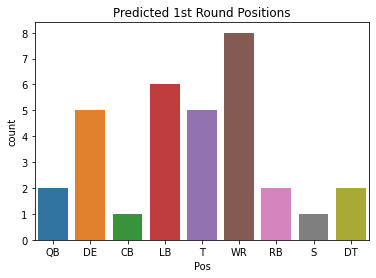

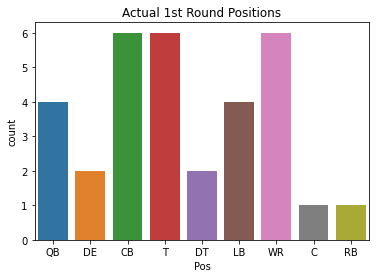

In [6]:
output_2020.loc[output_2020['Pick_Ordinal']<=32.0, 'Round1_Pred'] = 1
output_2020.loc[output_2020['Pick_Ordinal'] > 32.0, 'Round1_Pred'] = 0
output_2020.loc[output_2020['Actual_Pick']<=32.0, 'Round1_True'] = 1
output_2020.loc[output_2020['Actual_Pick'] > 32.0, 'Round1_True'] = 0
output_2020.loc[output_2020['Expert_Rank']<=32.0, 'Round1_Ex'] = 1
output_2020.loc[output_2020['Expert_Rank'] > 32.0, 'Round1_Ex'] = 0

display(output_2020.sort_values('Pick_Distance').head(10))

round1_pred = output_2020[output_2020['Round1_Pred']==1]
round1_true = output_2020[output_2020['Round1_True']==1]
round1_ex = output_2020[output_2020['Round1_Ex']==1]

sns.countplot(x='Pos', data=round1_pred)
plt.title('Predicted 1st Round Positions')

plt.figure()
sns.countplot(x='Pos', data=round1_true)
plt.title('Actual 1st Round Positions')

print('Correct 1st Round Predictions:', output_2020['Player'].loc[(output_2020['Round1_Pred']==1) & (output_2020['Round1_True']==1)].count())
print("Expert's Correct 1st Round Predictions:", output_2020['Player'].loc[(output_2020['Round1_Ex']==1) & (output_2020['Round1_True']==1)].count())

print('1st Rnd Approx. Value Sum, Vote Regressor:', round1_pred['AV/Yr'].sum())
print('1st Rnd Approx. Value Sum, Expert Model:', round1_ex['AV/Yr'].sum())
print('1st Rnd Approx. Value Sum, Actual Draft:', round1_true['AV/Yr'].sum())

Next, let's look at my model purely as a predictor of draft order. The entire first round is already printed above, and there you can see I greatly overvalued several players, but mostly defensive linemen. Here, I printed out the top 10 players that my model undervalued, and as you can see it's mostly made up of RBs, CBs and WRs. Even the other positions on here (QB, LB and Guard) are players that are lighter than average at their position. This continues to suggest that the model may be too strongly associating a heavier weight (and taller height in some cases) at each position with a higher draft pick. 

Overall I correctly predicted 12 players to go in the first round, while the expert's model predicted 19. In the graphs of position counts, you can see I was close with some positions (Tackles, LBs, WRs) and far off on others (DEs, CBs). However, I don't think this graph shows any inherent flaw in my model, at least with regards to weight and height, as it shows I was both accurate and inaccurate with both heavier and lighter positions. 

The final stat here is the sum of the AP/Yr column for each predicted first round and the actual first round. As you can see my model did the worst, followed by the expert's, and then by the actual NFL. This probably a good thing, as otherwise it would mean someone with no access to film or any real in depth knowledge of football strategy could predict player success just as well or better than professionals.

Overall, I am relatively pleased with my model's results actually, though I do plan on coming back and fine tuning it in the future, though probably using a different year as a test set. I also recognize that this model is not the ideal way to predict NFL player success, as I probably should've been training against a set that measured Approximate Value, not draft position. However, that was a decision I made after I started seeing that my model predicted some high perorming players (Justin Jefferson, Jonathan Taylor) to go much higher than they actually did. 

My final thoughts are that while much can be gleaned from physical measurements and college stats alone, they are not enough to tell the whole story of draft order and player success. While this analysis can't defintively answer whether scouts form biases of players based on stats and size before reviewing film, it does show that there is something more than stats and size that affects draft position. Film analysis, player personality, and team fit have been used to assess draft prospects for decades and, according to sums of each AV/Yr column, with good reason too. 